In [1]:
import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.callbacks import *

from matplotlib import pyplot as plt
import json

import sys
sys.path.append("..")
from generative_models import utils

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

/home/luca/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def combine_data(real_data, fake_data, split):    
    N_r = real_data.shape[0]
    N_f = fake_data.shape[0]
    
    x_train = np.vstack([real_data, fake_data]) 
    y_train = np.vstack([np.zeros((N_r, 1)), np.ones((N_f, 1))])

    N = x_train.shape[0]
    shuffled_indexes = np.random.permutation(N)

    x_train = x_train[shuffled_indexes]
    y_train = y_train[shuffled_indexes]

    split_index = int(N*split)

    x_test, x_train = x_train[:split_index], x_train[split_index:]
    y_test, y_train = y_train[:split_index], y_train[split_index:]
    
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])

    return (x_train, y_train), (x_test, y_test)

def build_classifier(timesteps):
    classifier = DecisionTreeClassifier(max_depth=5, max_features=1)
#     classifier = RandomForestClassifier(max_depth=5, max_features=1)
    return classifier

def evaluate_data(real_data, generated_data):
    (x_train, y_train), (x_test, y_test) = combine_data(real_data, generated_data, split)
    classifier = build_classifier(timesteps)
    classifier.fit(x_train, y_train)
    y_predicted = classifier.predict(x_test)

    plt.subplots(1, 2, figsize=(15, 4))
    
    plt.subplot(1, 2, 1)
    importances = classifier.feature_importances_
    plt.bar(range(len(importances)), importances)
    
    plt.subplot(1, 2, 2)
    cnf_matrix = confusion_matrix(y_test, y_predicted)
    plot_confusion_matrix(cnf_matrix, classes=['real', 'generated'],
                      title='Confusion matrix')
    plt.show()
    
    history = {}
    history['accuracy'] = metrics.accuracy_score(y_test, y_predicted)
    history['precision'] = metrics.precision_score(y_test, y_predicted)
    history['recall'] = metrics.recall_score(y_test, y_predicted)
    
    return history

def save_to_json(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4, sort_keys=True)

In [4]:
def run_comparison(real_data, generated_data_filepaths, labels):
    metrics = ['accuracy', 'precision', 'recall']
    histories = {}

    for index, filepath in enumerate(generated_data_filepaths):
        print(labels[index])
        generated_data = np.load(filepath)[:elements]
        generated_data = np.around(generated_data, 4)
        generated_data[np.abs(generated_data) <= (mean_value + 0.01)] = mean_value
        history = evaluate_data(real_data, generated_data)
        histories[labels[index]] = history

    plt.subplots(1, 3, figsize=(15, 4))
    for index, metric in enumerate(metrics):
        plt.subplot(1, 3, index+1)
        plt.title(metric)
        values = []
        for label in labels:
            history = histories[label]
            values.append(history[metric])
        axis = range(len(values))
        plt.bar(axis, values)
        plt.xticks(axis, labels, rotation=45)
        plt.ylim(min(values) - 0.01, 1)
    plt.show()
    
    return histories

## Models comparison

In [5]:
timesteps = 90
elements = 50000
split = 0.3

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]
real_data = np.around(real_data, 4)
mean_value = np.mean(real_data)

vanilla


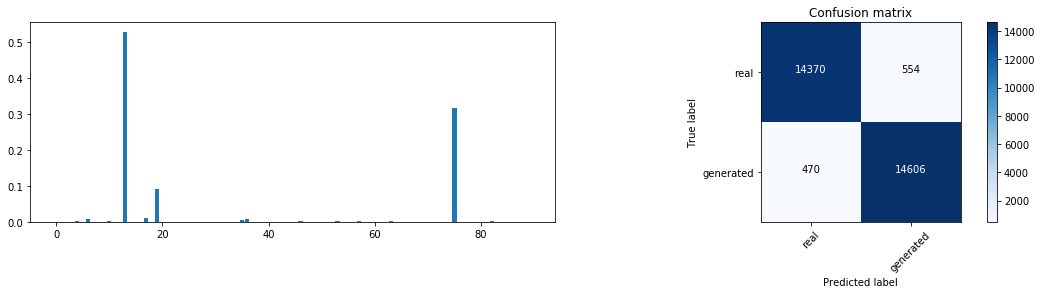

mbd


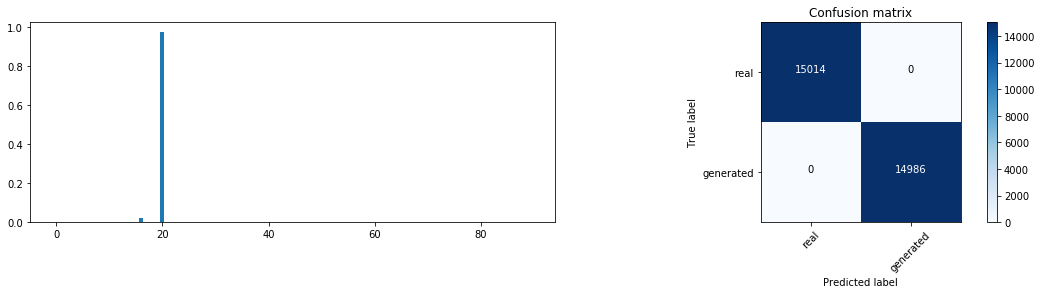

packing


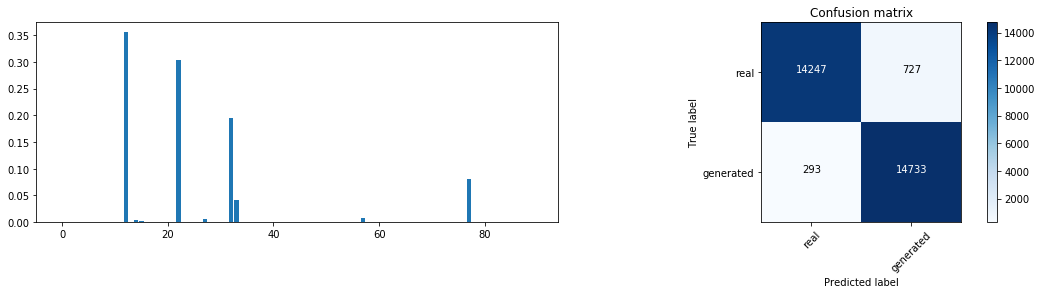

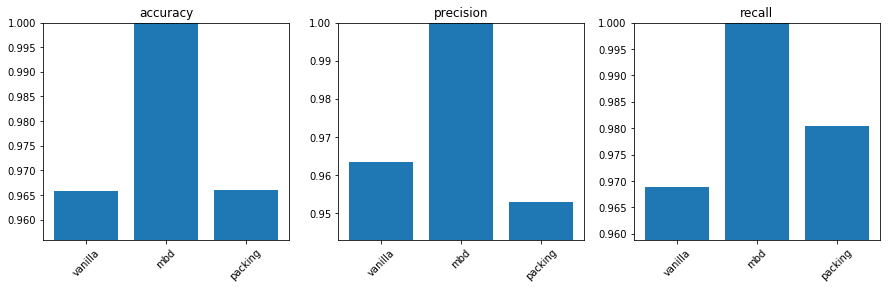

In [6]:
labels = ['vanilla', 'mbd', 'packing']

base_filepath = '../generative_models/wgan_gp/outputs/final/'
end_filename = 'generated_datasets/last.npy'
         
generated_data_filepaths = []
             
for label in labels:
    generated_data_filepaths.append(base_filepath + label + '/' + end_filename)
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
save_to_json('dt_classification_models_comparison.json', histories)

## Performance analysis during training

In [7]:
timesteps = 90
elements = 50000
split = 0.3

labels = ['100k', '200k', '300k', '400k', '500k', '600k', '700k', '800k', '900k', '1M']

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]

### Vanilla

100k


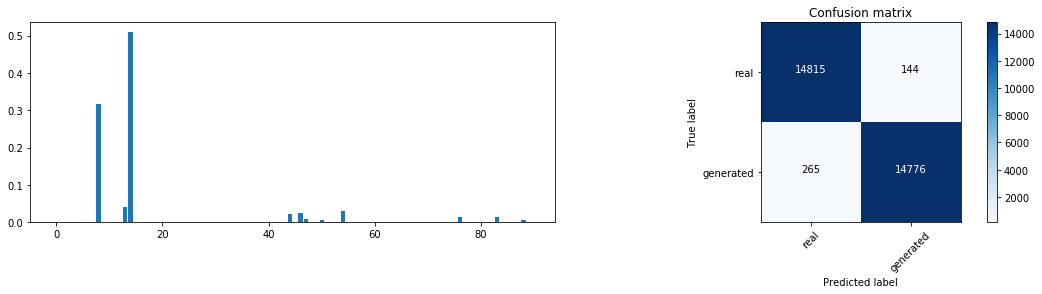

200k


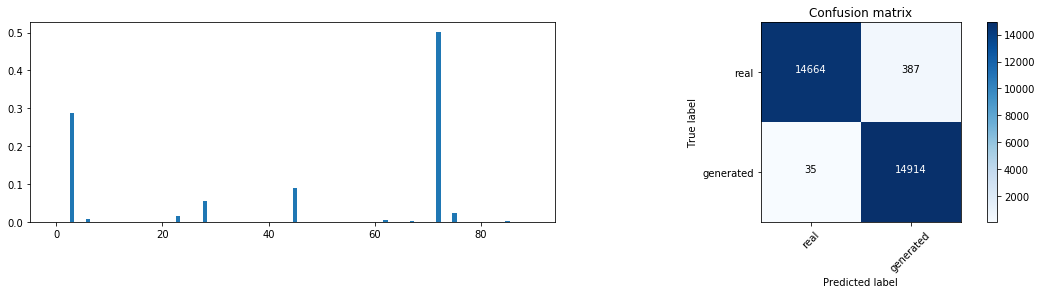

300k


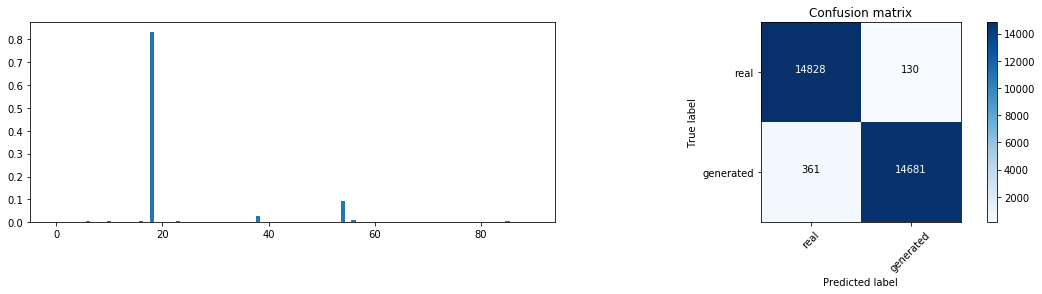

400k


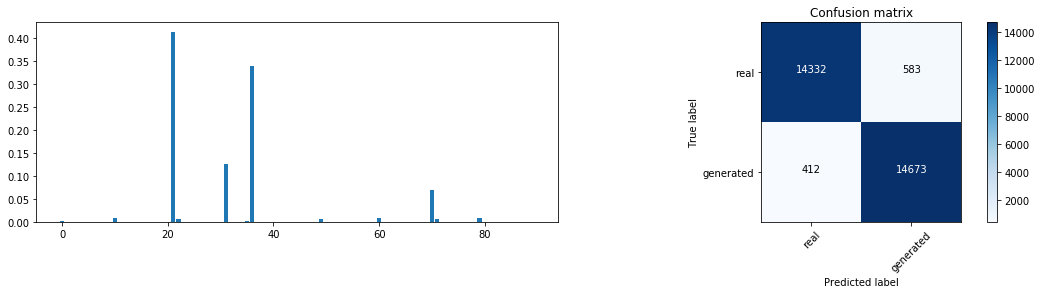

500k


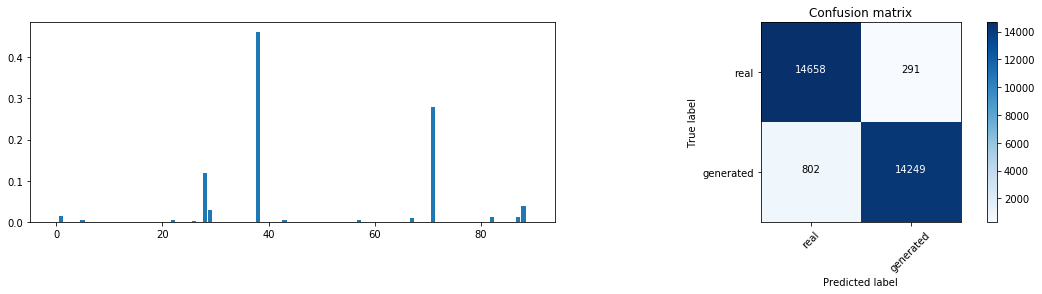

600k


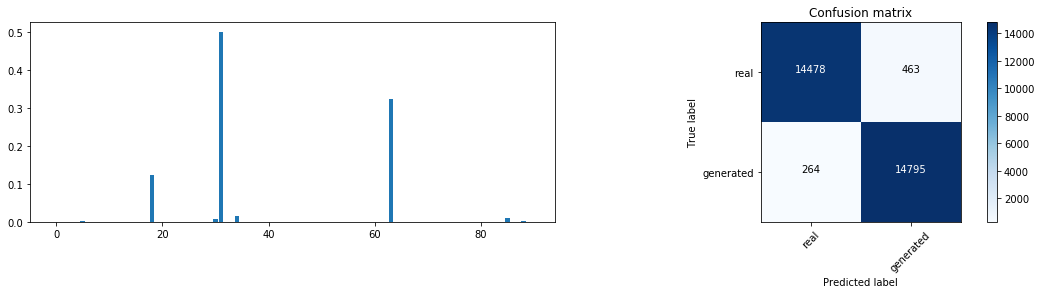

700k


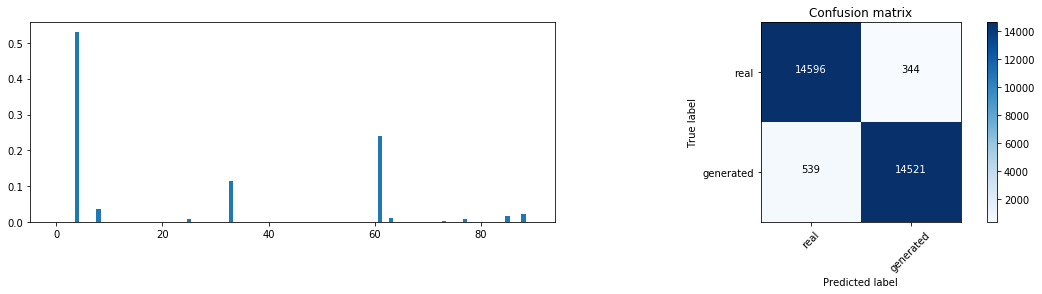

800k


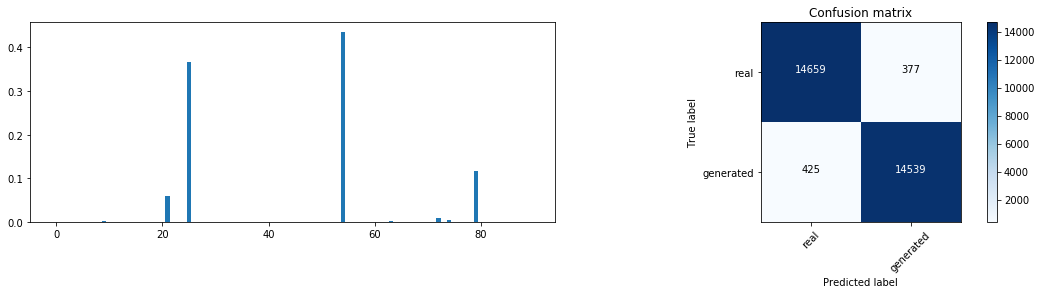

900k


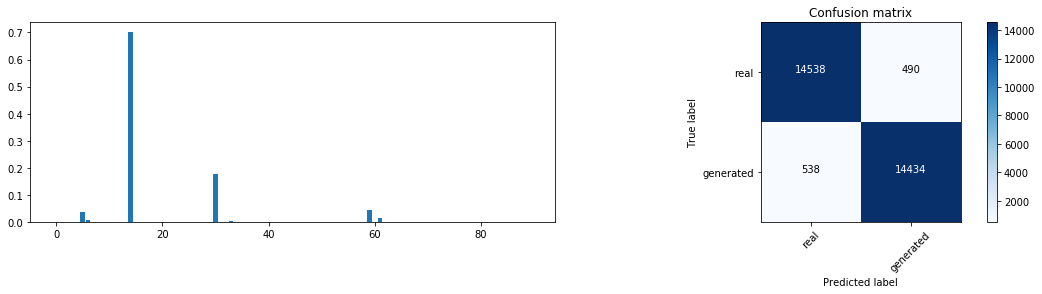

1M


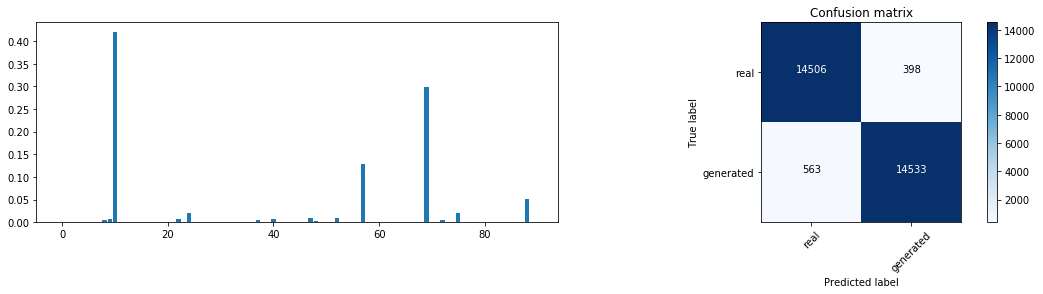

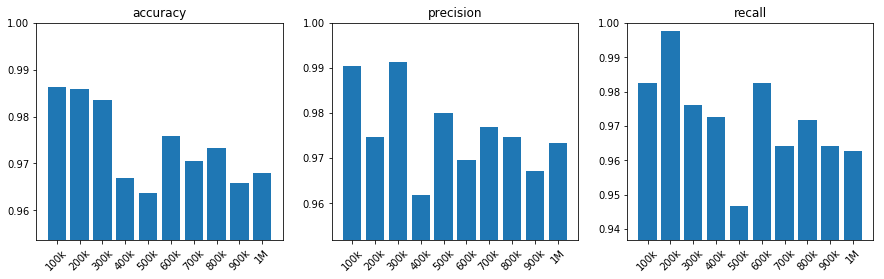

In [8]:
base_filepath = '../generative_models/wgan_gp/outputs/final/vanilla/generated_datasets/'
generated_data_filepaths = []

for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
save_to_json('dt_classification_vanilla.json', histories)

### Mbd

100k


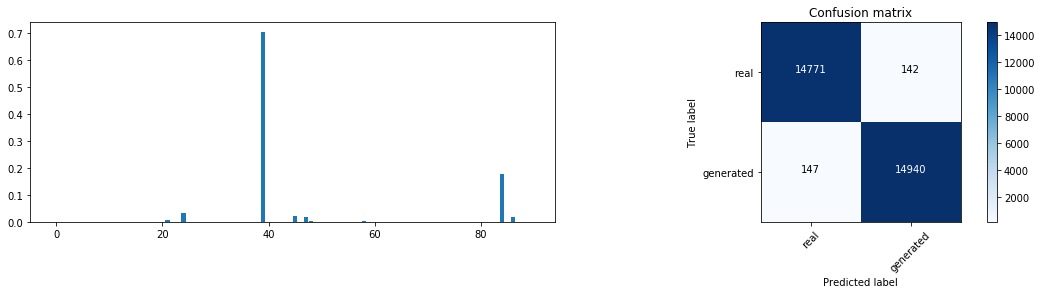

200k


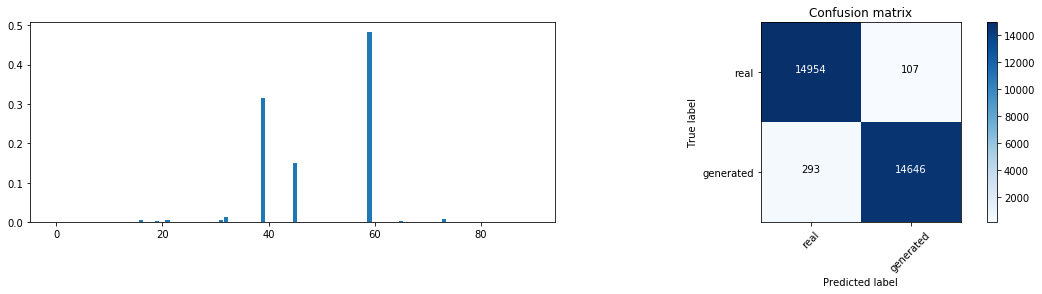

300k


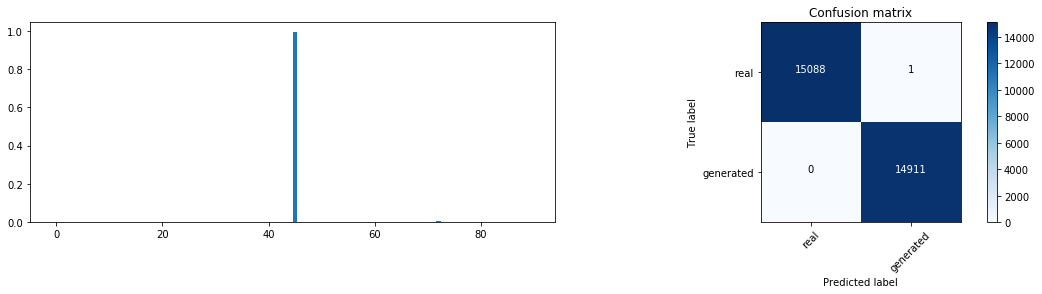

400k


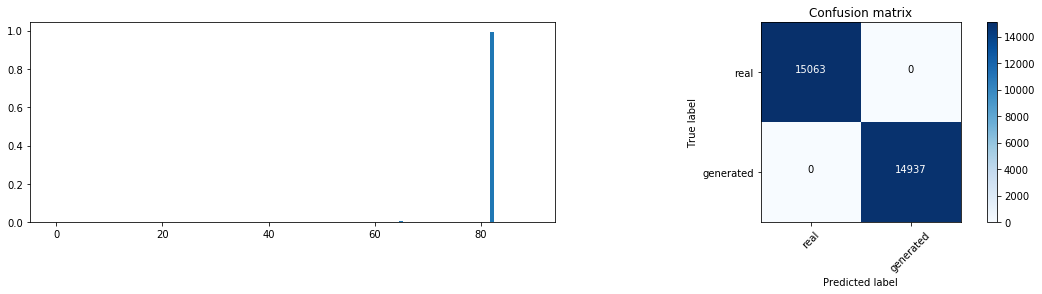

500k


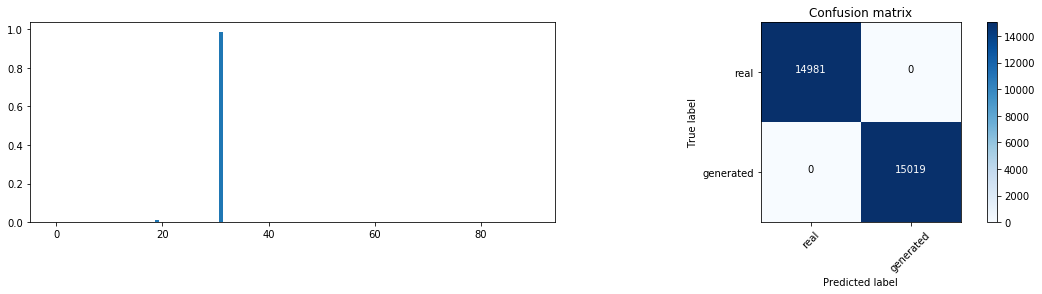

600k


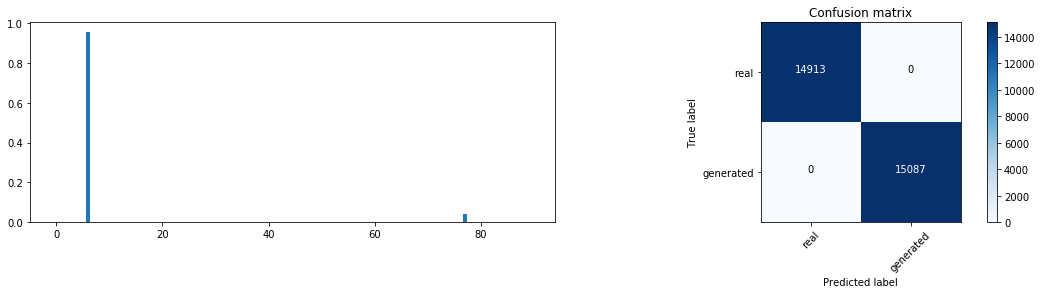

700k


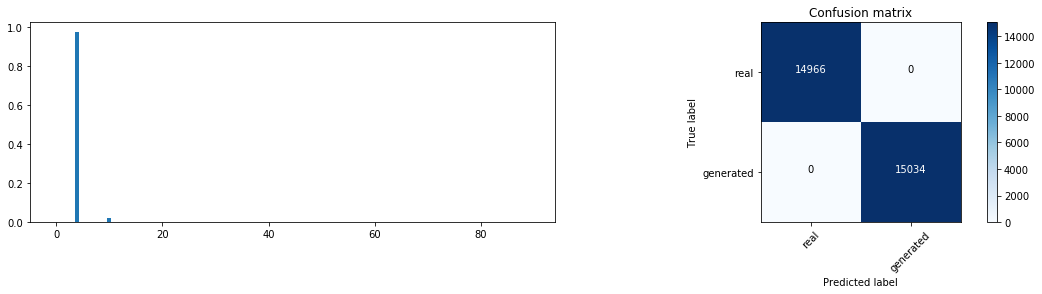

800k


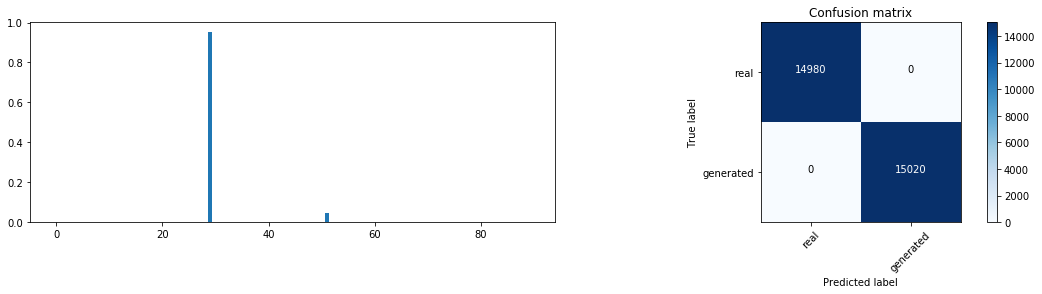

900k


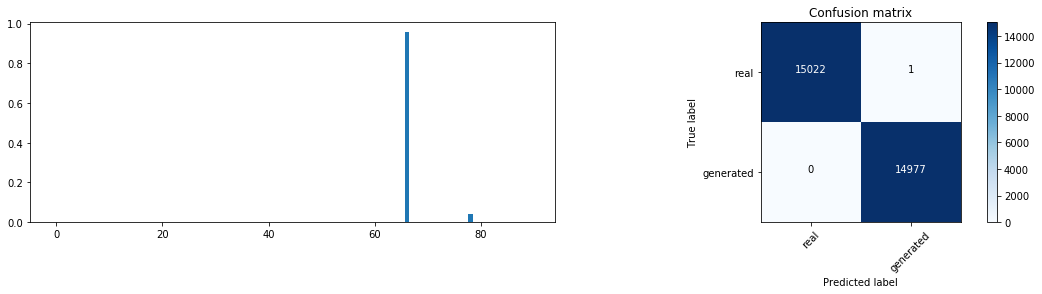

1M


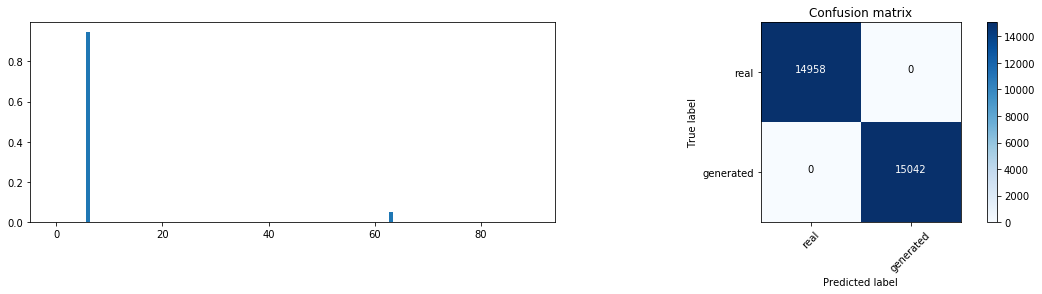

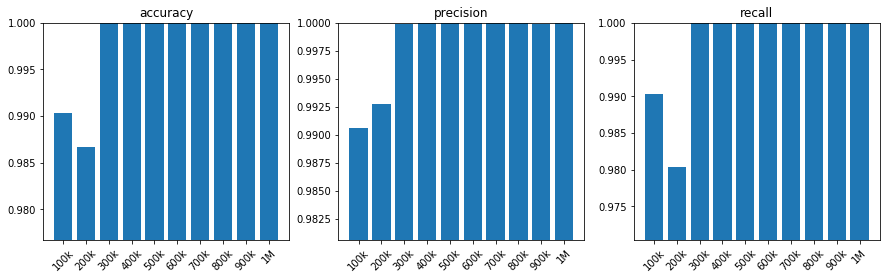

In [9]:
base_filepath = '../generative_models/wgan_gp/outputs/final/mbd/generated_datasets/'
generated_data_filepaths = []

for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
save_to_json('dt_classification_mbd.json', histories)

### Packing

100k


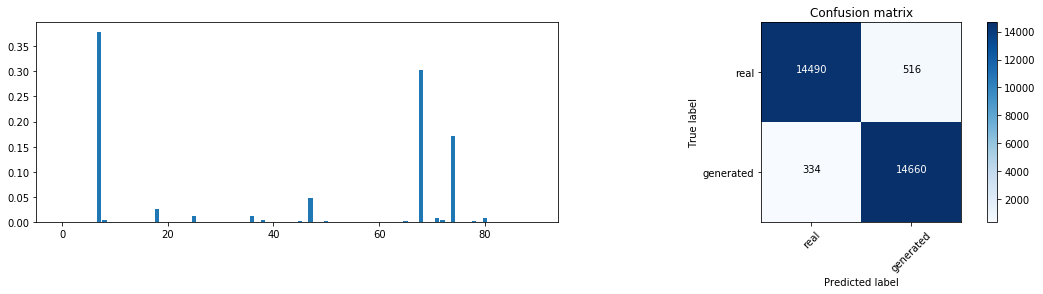

200k


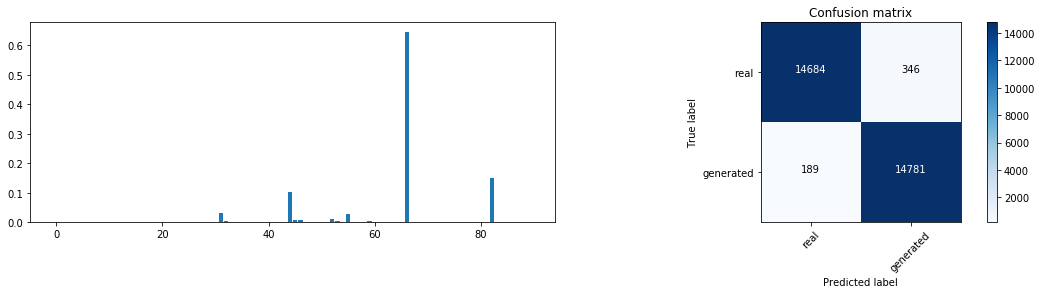

300k


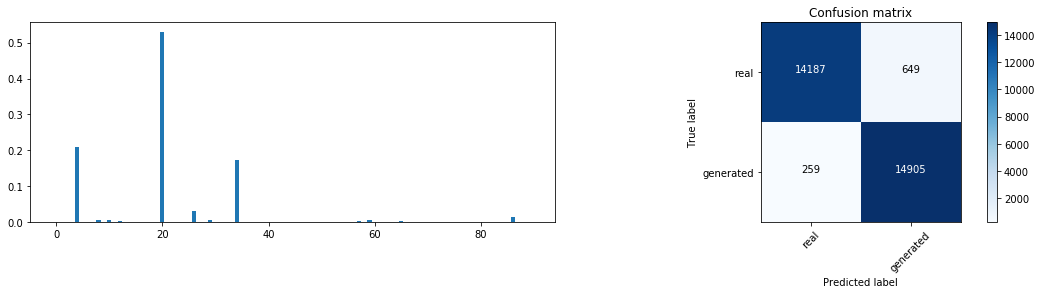

400k


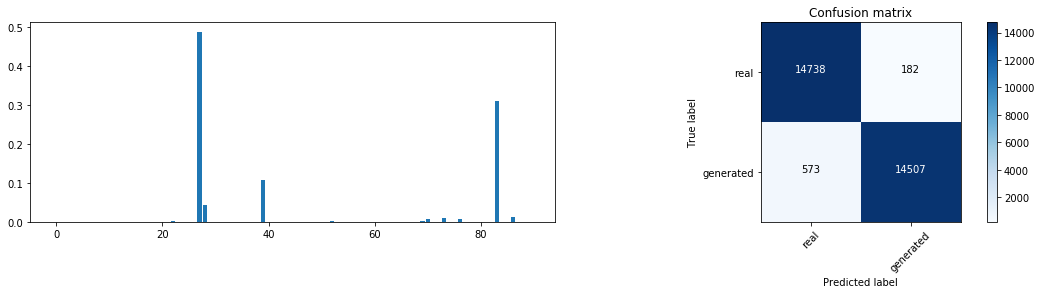

500k


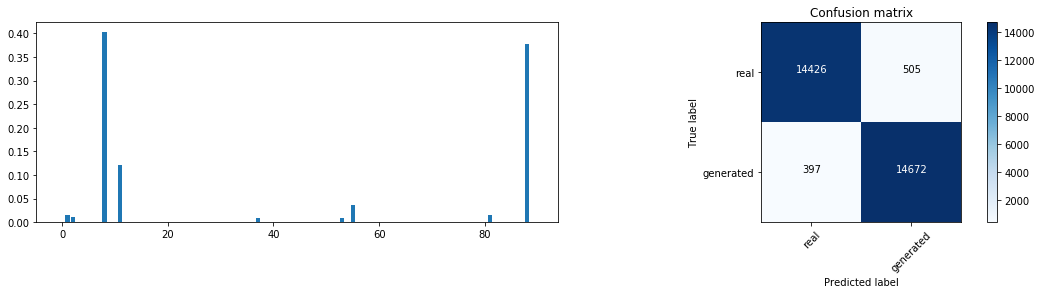

600k


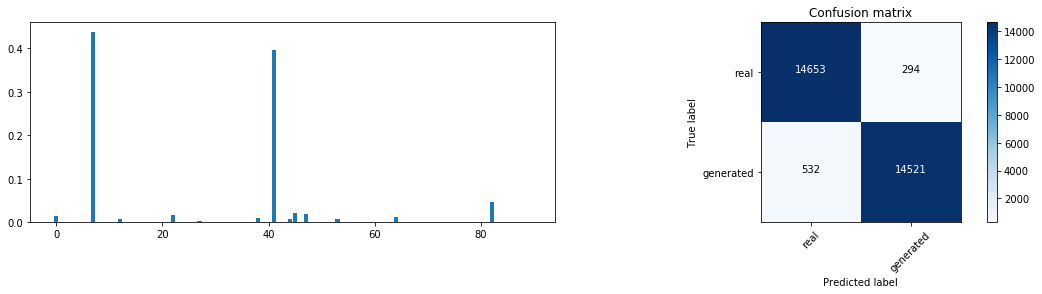

700k


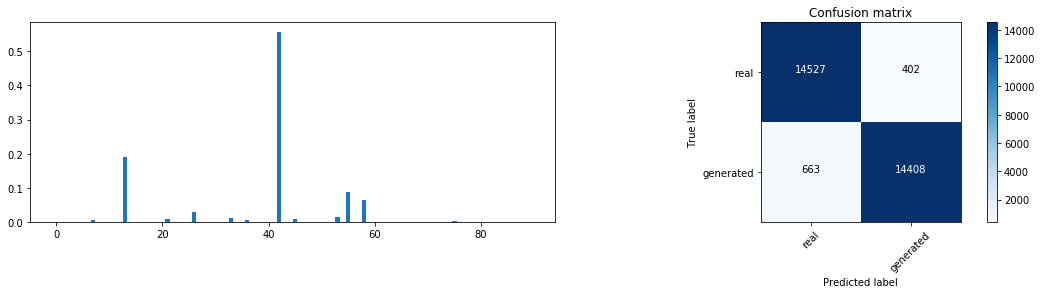

800k


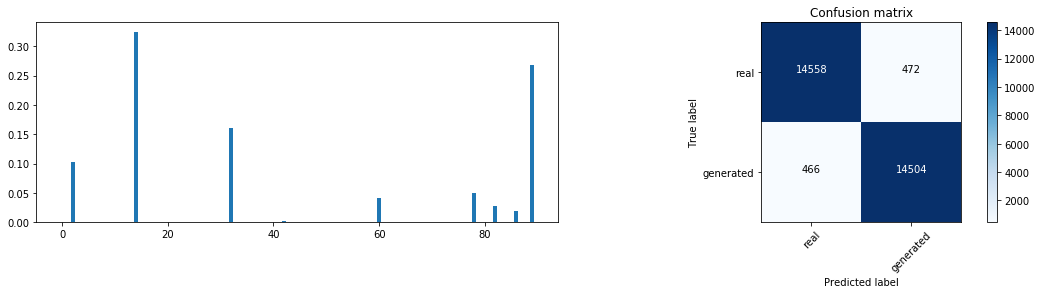

900k


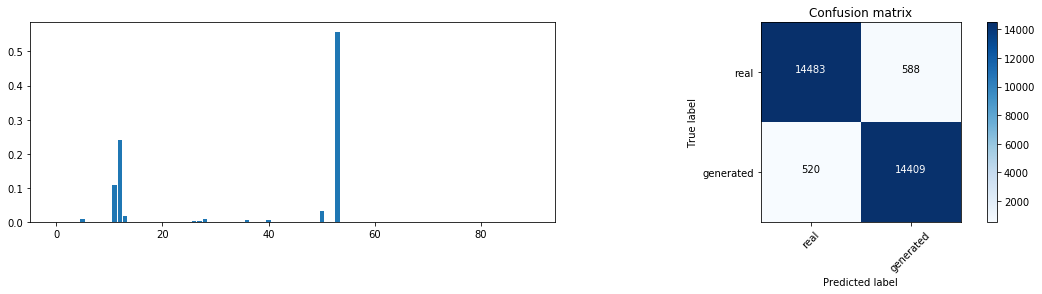

1M


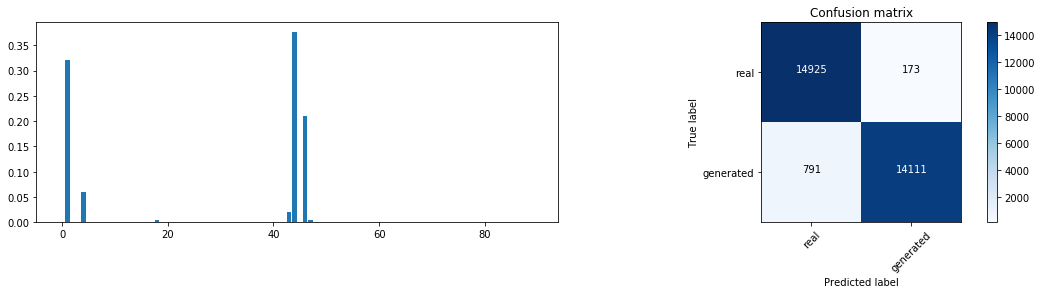

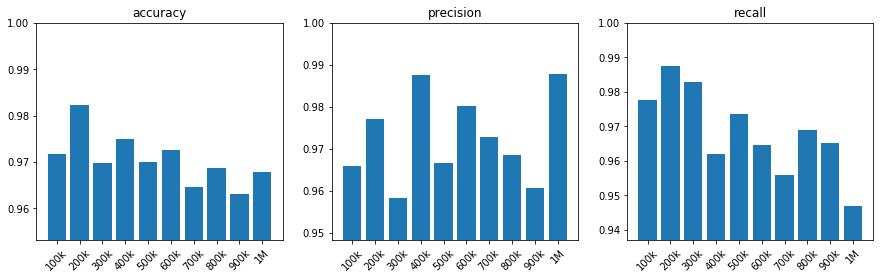

In [10]:
base_filepath = '../generative_models/wgan_gp/outputs/final/packing/generated_datasets/'
generated_data_filepaths = []

for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
save_to_json('dt_classification_packing.json', histories)